In [1]:
#setup
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSBSSSBB'
meas='TMAX'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+--------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|            res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+-------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+--------------------+-----------+-----------+------+--------------------+------+
| -408.6289133528315| -9.829547439770558|147.55458805715642|    112.2|BSBSSSBB| 33.0831| -83.2497|       TMAX|0.8374681913806987|0.8369276535951471|0.8157705543818145|0.040238749982838884|USC00095874|2.5383413E7|     3|[00 53 E0 58 F0 5...|1936.0|
|  255.7

### Plot Mean and Eigenvecs

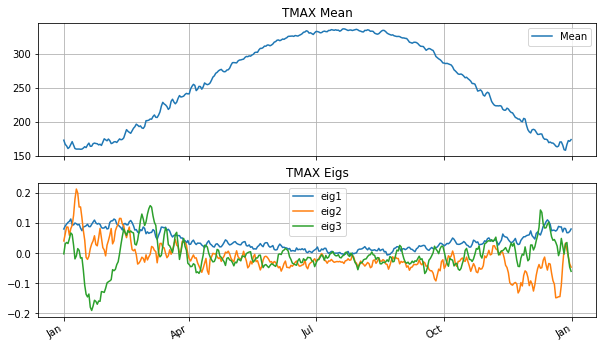

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

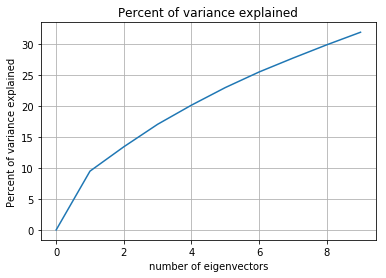

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

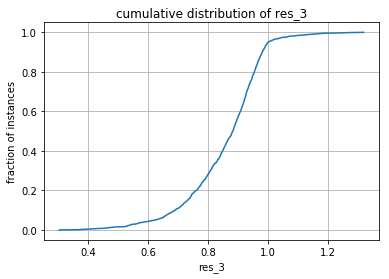

In [10]:
plot_CDF(df,'res_3')

In [11]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00095874', 1936.0)

In [12]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

43800

In [13]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [14]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [15]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00094238 1095
USC00098351 5023
USC00095696 1428
USC00094429 19212
USC00092839 32329
USC00095811 11588
USC00090090 4145
USR0000GWAY 2517
USC00090670 2885
USC00096255 1091
USW00013857 2920
USW00013870 22989
USC00098476 15220
USW00093845 7597
USC00093325 6719
USC00095386 10379
USC00095401 687
USC00095874 37508
USC00097777 17052
USR0000FOLU 2190
USC00095858 351
USC00096237 7831
USC00099020 720
USC00092996 4949
USC00089640 2496
USC00094862 2859
USC00084393 4677
USC00084394 19867
USC00093386 25686
USC00090131 23647
USR0000GBAX 2521
USC00092966 36876
USC00092844 726
USR0000GMET 2545
USC00096838 2153
USC00098972 4372
USC00097171 4358
USC00094170 33490
USC00090010 2129
USC00099186 36352
USC00093465 17519
USC00094971 1094
USC00094594 13625
USC00094204 10849
USC00094110 4352
USC00096244 3579
USC00099451 1086
USC00084731 39017
USC00098974 15560
USC00093312 3174
USC00095863 13405
USC00085275 33340
USC00090190 1455
USC00092865 2546
USC00092783 23221
USR0000GLOU 2536
USR0000GMCI 2525
USC00095492 7

In [16]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(68, 43800)


In [17]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


total RMS                   =  268.349503409
RMS removing mean-by-station=  74.3679361727
RMS removing mean-by-day   =  22.4881376734


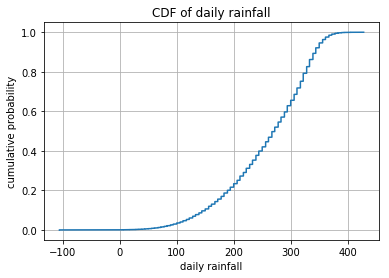

In [18]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [19]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [20]:
#USC00193270 21482
#USC00193702 28237
#USC00094238 1424
#USC00098351 3393
X=copy(All['USC00092783'])
Y=copy(All['USC00098351'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


23221
5023
2485
2485


In [21]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

m=2485,l=2485,n1=2485,n2=2485,LogPval=0.000000
(0.0, 2485)


### calculate the normalized log probability for each pair of stations.

In [22]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 m=1803,l=1803,n1=1803,n2=1803,LogPval=0.000000
m=12351,l=12350,n1=12350,n2=12351,LogPval=0.000000
m=20610,l=20607,n1=20609,n2=20608,LogPval=-0.000000
m=12683,l=12683,n1=12683,n2=12683,LogPval=0.000000
m=20060,l=20057,n1=20059,n2=20058,LogPval=-0.000000
m=2076,l=2076,n1=2076,n2=2076,LogPval=0.000000
m=1713,l=1713,n1=1713,n2=1713,LogPval=0.000000
m=3425,l=3425,n1=3425,n2=3425,LogPval=0.000000
m=12752,l=12745,n1=12751,n2=12746,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2458,l=2458,n1=2458,n2=2458,LogPval=0.000000
m=14954,l=14950,n1=14953,n2=14951,LogPval=-0.000000
m=19692,l=19682,n1=19691,n2=19683,LogPval=-0.000000
m=707,l=706,n1=707,n2=706,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=21409,l=21393,n1=21408,n2=21394,LogPval=-0.000000
m=690,l=689,n1=690,n2=689,LogPval=0.000000
m=3170,l=3170,n1=3170,n2=3170,LogPval=0.000000
m=5186,l=5186,n1=5186,n2=5186,LogPval=0.000000
m=15332,l=15328,n1=15331,n2=15329,LogPval=-0.000000
m=11954,l=11953,n1=11953,n2=11954,LogPval=0.000000
m=0,l=

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


m=15086,l=15078,n1=15083,n2=15081,LogPval=-0.000000
m=30074,l=30067,n1=30071,n2=30070,LogPval=-0.000000
m=16197,l=16192,n1=16194,n2=16194,LogPval=-0.000463
m=1394,l=1393,n1=1393,n2=1394,LogPval=0.000000
m=1387,l=1386,n1=1386,n2=1387,LogPval=0.000000
m=4143,l=4142,n1=4143,n2=4142,LogPval=-0.000000
m=20659,l=20649,n1=20659,n2=20649,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1760,l=1759,n1=1759,n2=1760,LogPval=0.000000
m=18066,l=18051,n1=18063,n2=18053,LogPval=-0.000340
m=27122,l=27090,n1=27120,n2=27092,LogPval=-0.000000
m=712,l=711,n1=712,n2=711,LogPval=0.000000
m=1786,l=1785,n1=1786,n2=1785,LogPval=0.000000
m=31200,l=31167,n1=31198,n2=31169,LogPval=-0.000000
m=3827,l=3818,n1=3827,n2=3818,LogPval=-0.000000
m=3137,l=3137,n1=3137,n2=3137,LogPval=0.000000
m=5225,l=5222,n1=5224,n2=5223,LogPval=-0.000000
m=19457,l=19446,n1=19456,n2=19447,LogPval=-0.000000
m=13826,l=13821,n1=13823,n2=13823,LogPval=-0.000531
m=2159,l=2157,n1=2159,n2=2157,LogPval=-0.000000
m=27911,l=27885,n1=27909,n2=27887

m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
11 m=2458,l=2458,n1=2458,n2=2458,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2884,l=2884,n1=2884,n2=2884,LogPval=0.000000
m=2490,l=2490,n1=2490,n2=2490,LogPval=0.000000
m=1742,l=1742,n1=1742,n2=1742,LogPval=0.000000
m=1760,l=1759,n1=1760,n2=1759,LogPval=0.000000
m=2461,l=2461,n1=2461,n2=2461,LogPval=0.000000
m=1053,l=1053,n1=1053,n2=1053,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2145,l=2145,n1=2145,n2=2145,LogPval=0.000000
m=695,l=694,n1=695,n2=694,LogPval=0.000000
m=721,l=720,n1=721,n2=720,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2485,l=2484,n1=2485,n2=2484,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2833,l=2833,n1=2833,n2=2833,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2158,l=2158,n1=2158

m=2168,l=2167,n1=2167,n2=2168,LogPval=0.000000
m=2176,l=2175,n1=2175,n2=2176,LogPval=-0.000000
m=2159,l=2158,n1=2158,n2=2159,LogPval=0.000000
m=2535,l=2534,n1=2534,n2=2535,LogPval=0.000000
m=4009,l=4001,n1=4001,n2=4007,LogPval=-0.003135
m=21032,l=21003,n1=21007,n2=21025,LogPval=-0.000798
m=7175,l=7167,n1=7168,n2=7173,LogPval=-0.000870
17 m=690,l=689,n1=689,n2=690,LogPval=0.000000
m=2081,l=2079,n1=2079,n2=2081,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=4220,l=4209,n1=4210,n2=4219,LogPval=-0.000001
m=699,l=699,n1=699,n2=699,LogPval=0.000000
m=3827,l=3818,n1=3818,n2=3827,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=4230,l=4217,n1=4220,n2=4225,LogPval=-0.002341
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2490,l=2482,n1=2484,n2=2485,LogPval=-0.006575
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1735,l=1732,n1=1732,n2=1734,LogPval=-0.003666
m=4567,l=4554,n1=4557,n2=4559,LogPval=-0.006085

m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
23 m=20673,l=20658,n1=20659,n2=20672,LogPval=-0.000000
m=3230,l=3229,n1=3229,n2=3230,LogPval=0.000000
m=14962,l=14944,n1=14946,n2=14959,LogPval=-0.000384
m=29929,l=29903,n1=29904,n2=29925,LogPval=-0.000668
m=15613,l=15596,n1=15597,n2=15611,LogPval=-0.000397
m=27911,l=27885,n1=27887,n2=27909,LogPval=-0.000000
m=2118,l=2118,n1=2118,n2=2118,LogPval=0.000000
m=1407,l=1407,n1=1407,n2=1407,LogPval=0.000000
m=3759,l=3757,n1=3757,n2=3759,LogPval=-0.000000
m=20860,l=20832,n1=20845,n2=20844,LogPval=-0.000748
m=356,l=355,n1=355,n2=355,LogPval=-0.016503
m=2510,l=2510,n1=2510,n2=2510,LogPval=0.000000
m=17902,l=17878,n1=17883,n2=17894,LogPval=-0.000932
m=26905,l=26865,n1=26880,n2=26879,LogPval=-0.002361
m

m=0,l=0,n1=0,n2=0,LogPval=nan
m=2824,l=2823,n1=2823,n2=2824,LogPval=-0.000000
m=2116,l=2115,n1=2115,n2=2116,LogPval=0.000000
m=693,l=692,n1=693,n2=692,LogPval=-0.000000
m=714,l=714,n1=714,n2=714,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2474,l=2472,n1=2473,n2=2473,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2807,l=2806,n1=2806,n2=2807,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2147,l=2146,n1=2146,n2=2147,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2480,l=2479,n1=2479,n2=2480,LogPval=0.000000
m=2840,l=2839,n1=2839,n2=2840,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2801,l=2800,n1=2800,n2=2801,LogPval=0.000000
m=1437,l=1436,n1=1437,n2=1436,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2832,l=2831,n1=2831,n2=2832,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=350,l=350,n1=350,n2=350,LogPval=0.000000
m=715,l=714,n1=714,n2=715,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1767,l=1766,n1=1766,n2=1767,LogPval=0.000000
m=0,l=0

m=0,l=0,n1=0,n2=0,LogPval=nan
m=1412,l=1412,n1=1412,n2=1412,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1427,l=1426,n1=1427,n2=1426,LogPval=0.000000
m=1388,l=1388,n1=1388,n2=1388,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1063,l=1063,n1=1063,n2=1063,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1081,l=1080,n1=1081,n2=1080,LogPval=0.000000
m=1403,l=1401,n1=1403,n2=1401,LogPval=-0.000000
m=1051,l=1051,n1=1051,n2=1051,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=726,l=724,n1=726,n2=724,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1395,l=1395,n1=1395,n2=1395,LogPval=0.000000
m=1390,l=1389,n1=1390,n2=1389,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1425,l=1425,n1=1425,n2=1425,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=14

m=3102,l=3100,n1=3101,n2=3101,LogPval=-0.000000
m=2511,l=2510,n1=2510,n2=2511,LogPval=0.000000
m=3549,l=3547,n1=3548,n2=3548,LogPval=-0.000000
m=2860,l=2858,n1=2859,n2=2859,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=349,l=349,n1=349,n2=349,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3579,l=3576,n1=3578,n2=3577,LogPval=-0.000000
m=2857,l=2852,n1=2856,n2=2853,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3571,l=3563,n1=3570,n2=3564,LogPval=-0.000001
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1369,l=1367,n1=1368,n2=1368,LogPval=-0.000001
m=3175,l=3171,n1=3174,n2=3172,LogPval=-0.000000
m=3521,l=3520,n1=3520,n2=3521,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3160,l=3155,n1=3159,n2=3156,LogPval=-0.000000
m=334,l=334,n1=334,n2=334,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3563,l=3561,n1=3562,n2=3562,LogPval=-0.000000
m=3165,l=

m=1723,l=1723,n1=1723,n2=1723,LogPval=0.000000
m=2058,l=2053,n1=2054,n2=2057,LogPval=-0.000001
m=4595,l=4585,n1=4589,n2=4590,LogPval=-0.001096
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2094,l=2091,n1=2091,n2=2094,LogPval=0.000000
m=15567,l=15528,n1=15540,n2=15553,LogPval=-0.000531
m=13748,l=13711,n1=13724,n2=13725,LogPval=-0.003764
m=363,l=362,n1=362,n2=362,LogPval=-0.016238
m=0,l=0,n1=0,n2=0,LogPval=nan
m=15539,l=15501,n1=15512,n2=15520,LogPval=-0.002624
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5216,l=5210,n1=5211,n2=5214,LogPval=-0.001200
m=13400,l=13375,n1=13378,n2=13390,LogPval=-0.003072
m=12846,l=12827,n1=12829,n2=12843,LogPval=-0.000431
m=0,l=0,n1=0,n2=0,LogPval=nan
m=11812,l=11790,n1=11795,n2=11803,LogPval=-0.001839
m=3536,l=3533,n1=3533,n2=3536,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=16221,l=16192,n1=16193,n2=16219,LogPval=-0.000350
m=12469,l=12440,n1=12452,n2=12450,LogPval=-0.002951
m=2064,l=2062,n1=2062,n2=2063,LogPval=-0.003362
m=1076,l=1076,n1=1076,n2=1

m=347,l=347,n1=347,n2=347,LogPval=0.000000
m=355,l=353,n1=355,n2=353,LogPval=0.000000
m=343,l=341,n1=343,n2=341,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=363,l=363,n1=363,n2=363,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=720,l=719,n1=720,n2=719,LogPval=0.000000
m=709,l=709,n1=709,n2=709,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=707,l=705,n1=707,n2=705,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=720,l=718,n1=720,n2=718,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=365,n1=365,n2=365,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1

m=3249,l=3247,n1=3249,n2=3247,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3551,l=3551,n1=3551,n2=3551,LogPval=0.000000
m=1071,l=1071,n1=1071,n2=1071,LogPval=0.000000
m=3248,l=3248,n1=3248,n2=3248,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3226,l=3220,n1=3226,n2=3220,LogPval=0.000000
m=3594,l=3594,n1=3594,n2=3594,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=3576,l=3576,n1=3576,n2=3576,LogPval=0.000000
m=2492,l=2491,n1=2492,n2=2491,LogPval=0.000000
m=1778,l=1777,n1=1778,n2=1777,LogPval=-0.000000
m=1067,l=1067,n1=1067,n2=1067,LogPval=0.000000
m=3620,l=3620,n1=3620,n2=3620,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=322,l=322,n1=322,n2=322,LogPval=0.000000
m=365,l=365,n1=365,n2=365,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1459,l=1459,n1=1459,n2=1459,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2875,l=2875,n1=2875,n2=2875,LogPval=0.000000
m=3578,l=3573,n1=3578,n2=3573,LogPval=-0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=337,l=337,n1

m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2914,l=2914,n1=2914,n2=2914,LogPval=0.000000
m=2494,l=2494,n1=2494,n2=2494,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=363,l=363,n1=363,n2=363,LogPval=0.000000
m=1095,l=1095,n1=1095,n2=1095,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=728,l=728,n1=728,n2=728,LogPval=0.000000
m=2859,l=2858,n1=2859,n2=2858,LogPval=-0.000000
m=1067,l=1067,n1=1067,n2=1067,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=730,l=730,n1=730,n2=730,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1084,l=1084,n1=1084,n2=1084,LogPval=0.000000
m=1035,l=1034,n1=1035,n2=1034,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1825,l=1825,n1=1825,n2=1825,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2919,l=2919,n1=2919,n2=2919,LogPval=0.000000
m=0,l=0,n1=0,n2=0,LogPval=n

In [23]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[    0.  1803.]
 [ 1803.     0.]]
[[-0.4  0. ]
 [ 0.  -0.4]]


(4624,) (2862,)


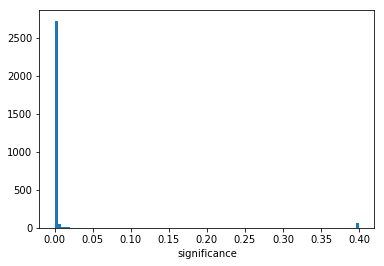

In [25]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

In [26]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

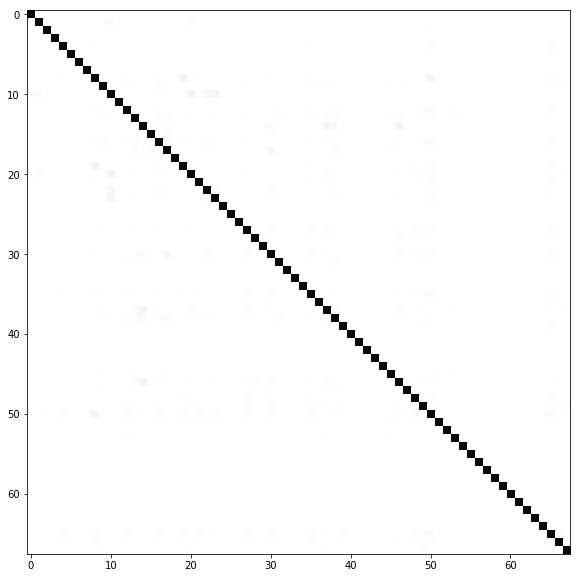

In [27]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [28]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00094238', u'USC00098351', u'USC00095696', u'USC00094429', u'USC00092839', u'USC00095811', u'USC00090090', u'USR0000GWAY']


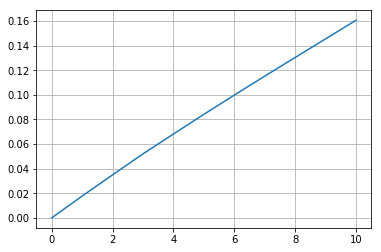

In [29]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [30]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

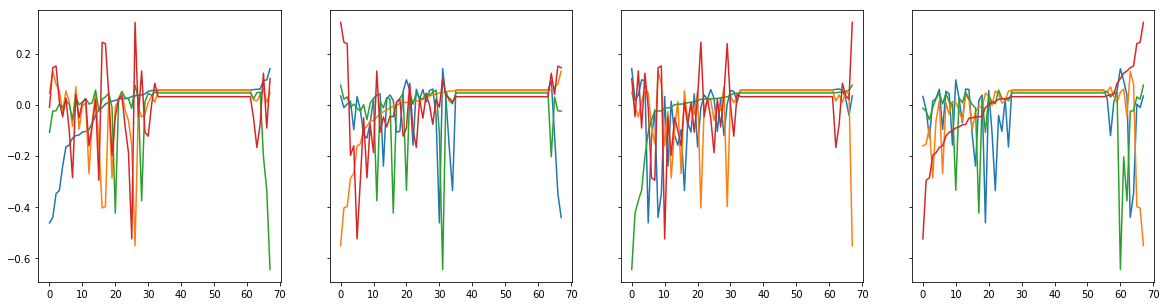

In [31]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [32]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

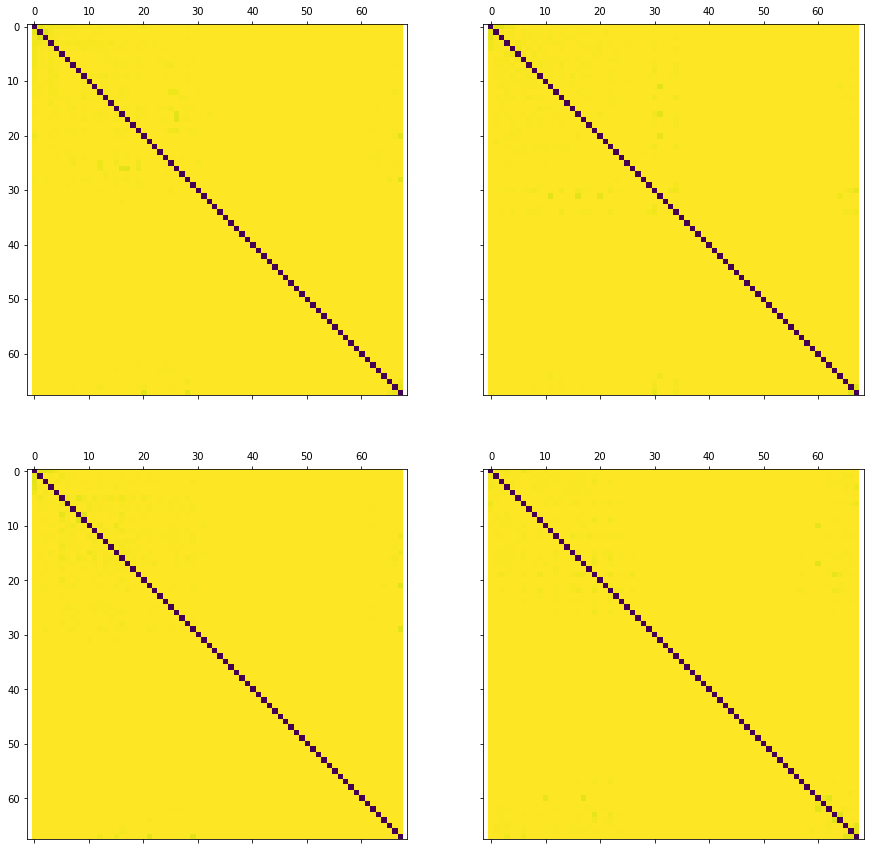

In [33]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [34]:
from pickle import dump
with open(data_dir+'/'+ meas+'_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    